<a href="https://colab.research.google.com/github/Fonzzy1/LLM-Workshop/blob/main/workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
execute:
  cache: true
jupyter: python3

---

<a href="https://colab.research.google.com/github/Fonzzy1/LLM-Workshop/blob/main/workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLMs for Communications Methods**
##### Presented at the ADM+S 2026 Summer School as the interactive component of
# **Integrating LLMs into communication research methods: Possibilities, assumptions and risks**


This session will provide users with a hands-on opportunity to see how language models can be integrated into communications research, and what possibilities and risks this presents.

<br>

*Authors: Alfie Chadwick and Laura Vodden*



---

# **🔨 Part 1. Setting up**


♦

### **1.1 Housekeeping**

**Before you proceed**

The default runtime type of Colab instances is CPU based. We will need to change our runtime type to **T4 GPU** or better.
Change this by either going to **Runtime > Change runtime type**

*or*

by going to the tiny arrow in the top right corner of your browser and selecting **Change runtime type**.

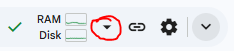

You should now see 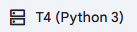 in the bottom right corner of your browser.

Source [here](https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb#scrollTo=o2ghppmRDFny).



♦

### **1.2 Using Colab Notebooks**

As we work through this notebook, we will run each code cell consecutively. When you mouse over each code block, a image.png button will appear in the top left corner of that cell. **Clicking** this will **run the code** in that cell.

Once the code has finished running, you will see a green tick and the time taken to run the code beside this button:

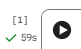

**Hint:** Look for the 🏃 emoji to know which cells to run.

<br>

<br>

✴

### **1.3 Set up ollama environment, and install and import libraries**
This should only take a minute or two.

In [24]:
#| eval: false
!sudo apt update
!sudo apt install -y pciutils zstd
!curl -fsSL https://ollama.com/install.sh | sh
!pip install ollama kagglehub kagglehub[pandas-datasets] pandas

import ollama
import os
import threading
import subprocess
import requests
import json
import matplotlib.pyplot as plt

def ollama_thread_function():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama_thread_function)
ollama_thread.start()

import pandas as pd
pd.set_option('display.max_colwidth', None)

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
119 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as r

<br>

✴

### **1.4 Model selection**

We are going to be using **four** Large Language Models today:
* Llama
* Qwen
* Gemma
* Deepseek



All of these models are **open source**, and all but Gemma are the same size.  
However, they will exhibit slight differences when we ask them the same
question.

For other models check https://ollama.com/library

<br>


> 🏃 **Run the cell below** to 'pull' our models from the ollama library. This could take up to 4 minutes.

In [2]:
!ollama pull llama3.1:8b
!ollama pull qwen3:8b
!ollama pull gemma3:4b
!ollama pull deepseek-r1:8b

print('Done!')





Done!


In [ ]:
# import os

# models = ['llama3.1:8b', 'qwen3:8b', 'gemma3:4b', 'deepseek-r1:8b']
# for model in models:
#   os.system(f"ollama pull {model}")
#   print(f"loading {model}")


**While this runs:**

✋ Does anybody need any assitance?

✋ Are there any concepts/jargon we should clarify?

<br>

---

<br>

✴

# **🤖 Part 2. Interacting with LLMs in Python**

Unlike interacting with a chat client online, using LLMs in Python is much more
flexible but takes a little time to set up.

In Python we can create **functions** - repeatable pieces of code using the `def`
syntax. We can pass **arguments** to these functions, which change how the function behaves.

Below is a function that takes two arguments:

1. a **prompt** (```prompt```); and
    
2. the name of the **model** we want to use (```mymodel```)



<br>

> 🏃 **Run the cell below** to **define** the **function**. This will not 'do' anything yet, but we will **call** this function later.

In [3]:
def query_llm(prompt, mymodel):

    # send the request with prompt and mymodel to ollama and get the full response
    response = ollama.chat(
        model=mymodel,
        messages=[{"role": "user",
                   "content": prompt}
                  ]
    )
    # extract response text from response
    response_text = response.message.content

    # return model text
    return response_text

<br>

♦

### **2.1 Running the LLMs**
Now that we have **defined** a working **function**, we need to define our **prompt** and **model** selection.

<br>

> ✍ Change the **prompt** in the cell below to something that is within your field of expertise - but try to ask for a brief response. Or, use one of the existing ones.

In [ ]:
# Examples (ctrl+/ to use):
# prompt = 'What is the role of performance in australian parliamentary debates'
# prompt = 'Briefly tell me: What does a cat say?'
prompt = 'In 100 words or less: What is the definition of framing in communication science?'

# prompt = 'YOUR OWN PROMPT HERE'

print(f'Your prompt:\n\n {prompt}\n')

<br>

> 🏃 **Run the cell below** to create a list of our **models**.

In [4]:
# select models
models = ['llama3.1:8b', 'qwen3:8b', 'gemma3:4b', 'deepseek-r1:8b']

print(f'Your models:\n\n {models}\n')

Your models:

 ['llama3.1:8b', 'qwen3:8b', 'gemma3:4b', 'deepseek-r1:8b']



We can now go and ask what each **model** says in response to our **prompt** using the **function** that
was defined above.

<br>


> 🏃 **Run the cell below** to **call** the function. Notice that we iterate through each `model` in the list, and pass the **same prompt** to each one as a `prompt` argument. The function **returns** a separate **response** each time, based on the `model` and `prompt` arguments. This may take up to 2 minutes to run.

In [ ]:
rows = []

# pass the prompt to each model in the list
for mymodel in models:
    print(f"{mymodel} is analysing your question...\n")

    response_text = query_llm(prompt, mymodel)

    rows.append({
        "model": mymodel,
        "response": response_text
    })

test_df = pd.DataFrame(rows)

test_df

**While this runs:**

✋ Does anybody need any assitance?

✋ Are there any concepts/jargon we should clarify?

<br>

✴

### **2.2 Visualising the outputs**

Let's have a look at the data. Does the response **length** very by model?

> 🏃 **Run the cell below** to **plot** response length by model.

In [ ]:
import matplotlib.pyplot as plt

# compute word counts for each model
word_counts = test_df.set_index('model')['response'].apply(lambda x: len(x.split()))

# plot
word_counts.plot(kind="bar", figsize=(8,5))
plt.ylabel("response word count")
plt.title("answer length (n words) by model\n")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> 🏃 **Run the cell below** to **plot** a word cloud for each model.

In [ ]:
from wordcloud import WordCloud
from matplotlib.patches import Rectangle
import pandas as pd
import re
from collections import Counter

# Simple stopword list
stop_words = {
    "the", "and", "of", "e", "g", "vs", "to", "s", "a", "in", "is", "it", "that", "as",
    "for", "with", "on", "by", "this", "are", "or", "an", "be",
    "from", "at", "which", "but", "not", "have", "has", "their",
    "its", "also", "can", "how", "such", "frame", "framing", "frames"
}

top_n = 10
rows = []

for _, row in test_df.iterrows():
    model = row["model"]
    text = str(row["response"]).lower()

    # Extract words
    words = re.findall(r"\b[a-zA-Z]+\b", text)

    # Remove stopwords
    words = [w for w in words if w not in stop_words]

    # Count top words
    counts = Counter(words).most_common(top_n)

    for rank, (word, count) in enumerate(counts, start=1):
        rows.append({
            "model": model,
            "rank": rank,
            "word": word,
            "count": count,
            "word_count": f"{word} ({count})"   # convenient display column
        })

# Create dataframe
top_words_df = pd.DataFrame(rows)

# Pivot to horizontal format
wide_df = top_words_df.pivot(index='model', columns='rank', values='word_count')
wide_df.columns = [f"top_{col}" for col in wide_df.columns]
wide_df.reset_index(inplace=True)




# Iterate over each model and make a word cloud
models = top_words_df["model"].unique()
plt.figure(figsize=(5 * len(models), 4))

for i, model in enumerate(models, 1):
    # Build frequency dictionary: {word: count}
    top_words = (
        top_words_df[top_words_df["model"] == model]
        .set_index("word")["count"]
        .to_dict()
    )

    ax = plt.subplot(1, len(models), i)
    wc = WordCloud(
        width=400,
        height=300,
        background_color="white",
        colormap="tab10"
    ).generate_from_frequencies(top_words)

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(model)

    # Add border rectangle
    rect = Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        fill=False, edgecolor="black", linewidth=2
    )
    ax.add_patch(rect)

plt.suptitle("Top Words per Model", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### **🧐 Questions**


> *  What did the models get **right**, and what did they get **wrong**?
> *  How did the response **differ** between the different models?
> *  Which model gave the 'best' response, and **why** do you think that?
> *  Is this kind of output **useful**?

<br>

<br>

---

<br>

♦


# **📓 Part 3. Using LLMs for communication research**

While we can use LLMs for question-answering tasks, as we did before, they are particularly for the **'busy work'** of research.


Tasks such as data **cleaning**, **labelling**, **classification** and **extraction** are relatively straightforward to automate and **validate**. By automating such processes, we can work with much larger datasets and address research questions at a different scale than would typically be feasible using manual methods.


While these approaches enable new analytical **possibilities**, they also introduce **risks** that warrant careful consideration. We will keep this in mind as we work through the following examples.



<br>



### **☝ Example: Narrative framing: Hero/villain extraction**

In this demo, we're going to expand on the work done by [Frermann et al.
(2023)](https://doi.org/10.18653/v1/2023.acl-long.486), which looks at how
**narrative actors** - in this case, heroes, victims and villains - are allocated within climate
discourse.



<br>

♦

## **3.1 Dataset selection**

Dataset selection is one of the most important parts of computational
communications tasks as it defines the scope of questions that can be answered
by your later analysis.

Today, we are using pre-built **Twitter Climate Change Sentiment** dataset from
[Kaggle](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset), for ease of access.

This dataset contains a sample of **tweets**, with their **sentiment** towards climate change
labeled as follows:


- **2 (News):** the tweet links to factual news about climate change  
- **1 (Pro):** the tweet **supports** the belief of anthropogenic climate change  
- **0 (Neutral):** the tweet **neither supports nor refutes** the belief of anthropogenic
  climate change  
- -**1 (Anti):** the tweet **refutes** the belief of anthropogenic climate change

<br>

> 🏃 **Run the cell below** to import the dataset and view the first five records.

In [5]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "twitter_sentiment_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "edqian/twitter-climate-change-sentiment-dataset",
  file_path,
)

print("First 5 records:\n")
df.head()

/tmp/ipython-input-404345684.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'twitter-climate-change-sentiment-dataset' dataset.
First 5 records:



,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦",793125156185137153


Now we can see the first few records and how the sentiment is distribuited.

<br>

> 🏃 **Run the cell below** to view the distribution of labels.

NameError: name 'plt' is not defined

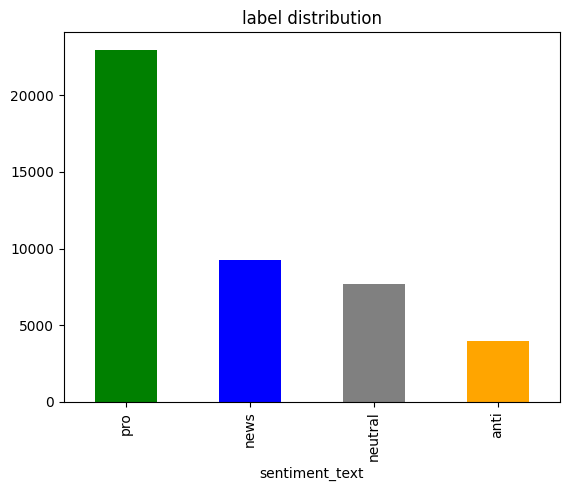

In [6]:
sentiment_map = {
    2: "news",
    1: "pro",
    0: "neutral",
    -1: "anti"
}

df["sentiment_text"] = df["sentiment"].map(sentiment_map)

df['sentiment_text'].value_counts().plot(title='label distribution', kind='bar', color=['green', 'blue', 'gray', 'orange'])

plt.xlabel("sentiment label")
plt.ylabel("tweet count")

<br>

✴

### **3.2 Data preprocessing and cleaning**

We will be dropping URLs, retweet prefixes, and non-ASCII characters to reduce platform-specific noise and standardise the text for analysis. This will have the effect of removing entities who are being tweeted at, rather than mentioned, and hopefully make the data easier for the LLMs to process.

<br>

> 🏃 **Run the cell below** to clean the tweets and view the cleaned text in our dataframe.

In [7]:
# remove urls
df['clean_message'] = df['message'].str.replace(r'http\S+|www\S+', '', regex=True)

# remove handle after 'RT @'
df['clean_message'] = df['clean_message'].str.replace(r'^RT\s+@\w+:\s*', '', regex=True)

# remove hashes (but not the whole hashtag)
df['clean_message'] = df['clean_message'].str.replace('#', '', regex=True)

# remove &amp;
df['clean_message'] = df['clean_message'].str.replace('&amp;', 'and', regex=True)

# drop ascii characters
df['clean_message'] = df['clean_message'].str.encode('ascii', 'ignore').str.decode('ascii')

# remove @ symbols
df['clean_message'] = df['clean_message'].str.replace('@', '', regex=True)

df[['message', 'clean_message']].head()

,message,clean_message
0,@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom,tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦","Watch BeforeTheFlood right here, as LeoDiCaprio travels the world to tackle climate change htt"
2,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https://t.co/7rV6BrmxjW via @youtube,Fabulous! Leonardo DiCaprio's film on climate change is brilliant!!! Do watch. via youtube
3,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate change. We all think thisÃ¢â‚¬Â¦ https://t.co/kNSTE8K8im,Just watched this amazing documentary by leonardodicaprio on climate change. We all think this
4,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change &amp; natural disasters on the poÃ¢â‚¬Â¦","Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of climate change and natural disasters on the po"


LLMs can be computationally (and fiscally) expensive to run, so it is usually a good idea to **limit testing** and **prompt refinement** to a **small sample** of the data, before applying your refined prompt to the broader dataset.

<br>

> 🏃 **Run the cell below** select a random sample of tweets.


In [16]:
# for testing -  take a sample
df_samp = df.groupby('sentiment_text', group_keys=False).apply(lambda x: x.sample(min(len(x), 5), random_state=0))
df_samp[['tweetid', 'clean_message', 'sentiment_text']].head(10)

/tmp/ipython-input-380817775.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_samp = df.groupby('sentiment_text', group_keys=False).apply(lambda x: x.sample(min(len(x), 5), random_state=0))


,tweetid,clean_message,sentiment_text
21394,867499534787768321,Seeing liberal leaders tweet frantically about the deadly nature of climate change but not radical Islam is truly someth,anti
30417,953980941214670851,"UMM WUT? Bill Nye claims HOT SUMMERS are proof of climate change, gets SCHOOLED on seasons via Sam J.",anti
15451,841154331785093120,"TammyOnorato go for reasons other than climate change, and it's possible that the climate has been changing independent of humans as well.",anti
12699,828320850810109952,NOAA sr officials played fast and loose w/data in order 2 meet politically predetermined conclusion on climate change htt,anti
9718,810472774225502209,"Yet BarackObama will be hailed a hero by the climate change mental heads ITS AGAINST THE LAW,TO KILL BALD EAGLES b",anti
15128,840642726647480324,yeah global warming where ever u r at all the hot air coming from ur mouth,neutral
31956,963717325081006082,foxandfriends Burglar : darn global warming,neutral
36913,601352648210677761,Please stop global warming...,neutral
24847,892042757086334976,D1dupre96 They probably won't bring up his past climate change predictions,neutral
11702,822935383155605504,"Charlie Clark talks Uber, climate change and fentanyl at mayors' meeting with Trudeau uber",neutral


<br>

✴

### **3.3 Building the infrustructure**

While we have the data and the models, we need the code to make them interact
with each other. So, before we start writing prompts, we need to have a look at
how we can make the LLM interact with the data in a clean and reproducible way.

The first thing to do is build a response format. Think of this as **the form that
the LLM will fill out** when we ask it to look at tweet. In our example, we are
asking the LLM to identify the **hero**, the **villain** and the **victim** in each tweet, so
our response format will look something like this:

<br>

> 🏃 **Run the cell below** to define our **response format**.

In [17]:
from pydantic import BaseModel
from typing import Optional

class ResponseFormat(BaseModel):
    hero: Optional[str] = None
    victim: Optional[str] = None
    villain: Optional[str] = None

The second thing we need is a new **function** that can use this response format and feed the data to the model.

<br>

> 🏃 **Run the cell below** to define our new function. Again, this will not 'do' anything just yet, but we will **call** it in a moment.

In [25]:
from tqdm import tqdm

def query_llm_prompting(df_samp, mymodel, response_format, prompt):
    # make a copy so the original df_samp is untouched
    df_result = df_samp.copy()

    # get the columns from the response format
    cols = response_format.__fields__.keys()
    for col in cols:
        df_result[col] = None

    # iterate through each row in the dataframe
    for idx, row in tqdm(df_result.iterrows(), total=len(df_result)):
        response = ollama.chat(
            model=mymodel,
            messages=[
                {'role': 'system', 'content': prompt},
                {'role': 'user', 'content': row['clean_message']}
            ],
            format=response_format.model_json_schema(),
        )

        # extract text from full response
        parsed_response = response_format.model_validate_json(response.message.content)

        for col in cols:
            df_result.at[idx, col] = getattr(parsed_response, col)


    return df_result

---
# **🔧 Part 4. Prompt engineering**



✴

### **4.1 Model Selection**
In this section, we will work into groups and each run a pre-determined model, developing and refining our prompt as we go. We will then take a few minutes to discuss the differences in the outputs between each model.

<br>

> 🏃 **Run the cell below** to select your model.

In [26]:
mymodel = 'llama3.1:8b'
print(f"Using model:\n\n {model}\n")

Using model:

 llama3.1:8b



<br>

♦

### **4.2 Zero-shot prompting**

**Zero-shot prompting** is the form of LLM prompting that benefits only from the **knowledge contained within the LLM itself**. Instructions are provided, with no examples of the desired output.

<br>

> 🏃 **Run the cell below** to define your zero-shot prompt.

In [27]:
prompt_zeroshot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task: Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Extract from the text the names of entities (people, groups, organisations) that are explicitly  or implicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

<br>

> 🏃 **Run the cell below** to pass this **zero-shot prompt** to the model, and view the response.

In [30]:
response_format = ResponseFormat()
response_df_zeroshot = query_llm_prompting(df_samp, mymodel, response_format, prompt=prompt_zeroshot)
# response_df_zeroshot = transform_data(df_samp, mymodel, response_format, prompt=prompt_zeroshot)


response_df_zeroshot[['clean_message', 'hero', 'villain', 'victim']]

/tmp/ipython-input-4254469634.py:8: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


,clean_message,hero,villain,victim
21394,Seeing liberal leaders tweet frantically about the deadly nature of climate change but not radical Islam is truly someth,None,liberal leaders,None
30417,"UMM WUT? Bill Nye claims HOT SUMMERS are proof of climate change, gets SCHOOLED on seasons via Sam J.",None,Bill Nye,None
15451,"TammyOnorato go for reasons other than climate change, and it's possible that the climate has been changing independent of humans as well.",None,Humans (implicitly),None
12699,NOAA sr officials played fast and loose w/data in order 2 meet politically predetermined conclusion on climate change htt,None,NOAA sr officials,None
9718,"Yet BarackObama will be hailed a hero by the climate change mental heads ITS AGAINST THE LAW,TO KILL BALD EAGLES b",Barack Obama,None,None
15128,yeah global warming where ever u r at all the hot air coming from ur mouth,None,you,None
31956,foxandfriends Burglar : darn global warming,None,global warming,None
36913,Please stop global warming...,None,None,None
24847,D1dupre96 They probably won't bring up his past climate change predictions,None,None,None
11702,"Charlie Clark talks Uber, climate change and fentanyl at mayors' meeting with Trudeau uber",None,Uber,None


**While this runs:**

✋ Who is the 'helpful research assitant'?

✋ What knowledge is the language model drawing from?



<br>

✴

### **4.3 Few-shot prompting**

**Few-shot prompting** is a prompting technique in which a small number of examples of the desired output are provided, to give the model an opportunity to learn patterns and follow these in the output.


<br>

> 🏃 **Run the cell below** to define your zero-shot prompt. Notice that the examples provided give a clear image of the expected output.

In [31]:
prompt_fewshot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task: Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Examples:
1. Theresa May's new chief of staff, Gavin Barwell, is known for his knowledgable concern about climate change
    hero: Gavin Barwell
    victim: None
    villain: None

2. The reality of climate change impacts everyone but the truth is that poor communities suffer most...perpetuating the injustice
    hero: None
    victim: poor communities
    villain: climate change

3. Anti-Trump actor fights global warming, but wont give up 14 homes and private jet
    hero: Anti-Trump actor
    victim: None
    villain: Anti-Trump actor

Extract from the text the names of entities (people, groups, organisations) that are explicitly or implicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

<br>

> 🏃 **Run the cell below** to pass this **few-shot prompt** to the model, and view the response.

In [32]:
response_df_fewshot = query_llm_prompting(df_samp, mymodel, response_format, prompt=prompt_fewshot)

response_df_fewshot[['clean_message', 'hero', 'villain', 'victim']]

/tmp/ipython-input-4254469634.py:8: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


,clean_message,hero,villain,victim
21394,Seeing liberal leaders tweet frantically about the deadly nature of climate change but not radical Islam is truly someth,No explicit heroes mentioned,liberal leaders,None
30417,"UMM WUT? Bill Nye claims HOT SUMMERS are proof of climate change, gets SCHOOLED on seasons via Sam J.",Sam J,Bill Nye,None
15451,"TammyOnorato go for reasons other than climate change, and it's possible that the climate has been changing independent of humans as well.",Not mentioned,Not mentioned,None
12699,NOAA sr officials played fast and loose w/data in order 2 meet politically predetermined conclusion on climate change htt,None,NOAA sr officials,None
9718,"Yet BarackObama will be hailed a hero by the climate change mental heads ITS AGAINST THE LAW,TO KILL BALD EAGLES b",Barack Obama,climate change mental heads,None
15128,yeah global warming where ever u r at all the hot air coming from ur mouth,None,global warming,None
31956,foxandfriends Burglar : darn global warming,None,"global warming (implied to be caused by human activity, but the cause is not explicitly stated, so it's framed as a villain indirectly) or possibly the burglar (no indication that they are contributing to issue resolution, but no clear framing either)",None
36913,Please stop global warming...,None,global warming,None
24847,D1dupre96 They probably won't bring up his past climate change predictions,Donald Trump,None,None
11702,"Charlie Clark talks Uber, climate change and fentanyl at mayors' meeting with Trudeau uber",None,None,None


**While this runs:**

✋ Where do our examples come from?

✋ Could this bias the LLMs responses, and how?




<br>

♦

### **4.4 Step-by-step guidance**

We are now going to try a prompting technique that guides the LLM through the task step-by-step, providing a logical flow for the analysis, as well as examples. It is common also to have the LLM provide some sort of justification for its response, which is useful for interpretability.


In [33]:
prompt_cot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task:
Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Examples:
1. Theresa May's new chief of staff, Gavin Barwell, is known for his knowledgable concern about climate change
    hero: Gavin Barwell
    victim: None
    villain: None

2. The reality of climate change impacts everyone but the truth is that poor communities suffer most...perpetuating the injustice
    hero: None
    victim: poor communities
    villain: climate change

3. Anti-Trump actor fights global warming, but wont give up 14 homes and private jet
    hero: Anti-Trump actor
    victim: None
    villain: Anti-Trump actor

Chain of thought:
1. Identify the central issue: Determine what climate-related problem or event the tweet is discussing.
2. Look for conflict or tension: Check if the tweet highlights a problem, blame, praise, or action.
3. Detect heroes: Identify entities praised for mitigating or solving the issue.
4. Detect victims: Identify entities suffering negative consequences of the issue.
5. Detect villains: Identify entities blamed for causing or worsening the issue.

Extract from the text the names of entities (people, groups, organisations) that are explicitly or implicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

<br>

> 🏃 **Run the cell below** to pass this **chain-of-thought prompt** to the model, and view the response.

In [34]:
class CoT_ResponseFormat(BaseModel):
    hero: Optional[str] = None
    victim: Optional[str] = None
    villain: Optional[str] = None
    reasoning: Optional[str] = None

response_format = CoT_ResponseFormat()
response_df_cot = query_llm_prompting(df_samp, mymodel, response_format, prompt=prompt_cot)

response_df_cot[['clean_message', 'hero', 'villain', 'victim', 'reasoning']]

/tmp/ipython-input-4254469634.py:8: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


,clean_message,hero,villain,victim,reasoning
21394,Seeing liberal leaders tweet frantically about the deadly nature of climate change but not radical Islam is truly someth,None,liberal leaders,None,None
30417,"UMM WUT? Bill Nye claims HOT SUMMERS are proof of climate change, gets SCHOOLED on seasons via Sam J.",Bill Nye,Sam J.,None,The central issue is climate change and its relation to hot summers.
15451,"TammyOnorato go for reasons other than climate change, and it's possible that the climate has been changing independent of humans as well.",TammyOnorato,None,None,None
12699,NOAA sr officials played fast and loose w/data in order 2 meet politically predetermined conclusion on climate change htt,None,NOAA sr officials,None,accused of altering data for political reasons
9718,"Yet BarackObama will be hailed a hero by the climate change mental heads ITS AGAINST THE LAW,TO KILL BALD EAGLES b",None,None,None,None
15128,yeah global warming where ever u r at all the hot air coming from ur mouth,None,climate change,None,None
31956,foxandfriends Burglar : darn global warming,None,global warming,None,cause of the problem
36913,Please stop global warming...,None,global warming,None,None
24847,D1dupre96 They probably won't bring up his past climate change predictions,his,None,None,None
11702,"Charlie Clark talks Uber, climate change and fentanyl at mayors' meeting with Trudeau uber",Charlie Clark,None,None,Charlie Clark is a local leader participating in a discussion


**While this runs:**

✋ We asked the LLM to justify its response, but **can we trust this**?

✋ Was the justification provided **before** or **after** the response was generated?

<br>


<br>

---

<br>

✴

# **🔎 Part 5. Comparing results**

Let's see how the responses differed between models and across different prompting styles.

<br>

> 🏃 **Run the cell below** to plot a heat map of your model's annotations for each prompting style.








/tmp/ipython-input-2734479131.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[outcomes] = df[outcomes].applymap(clean_empty)


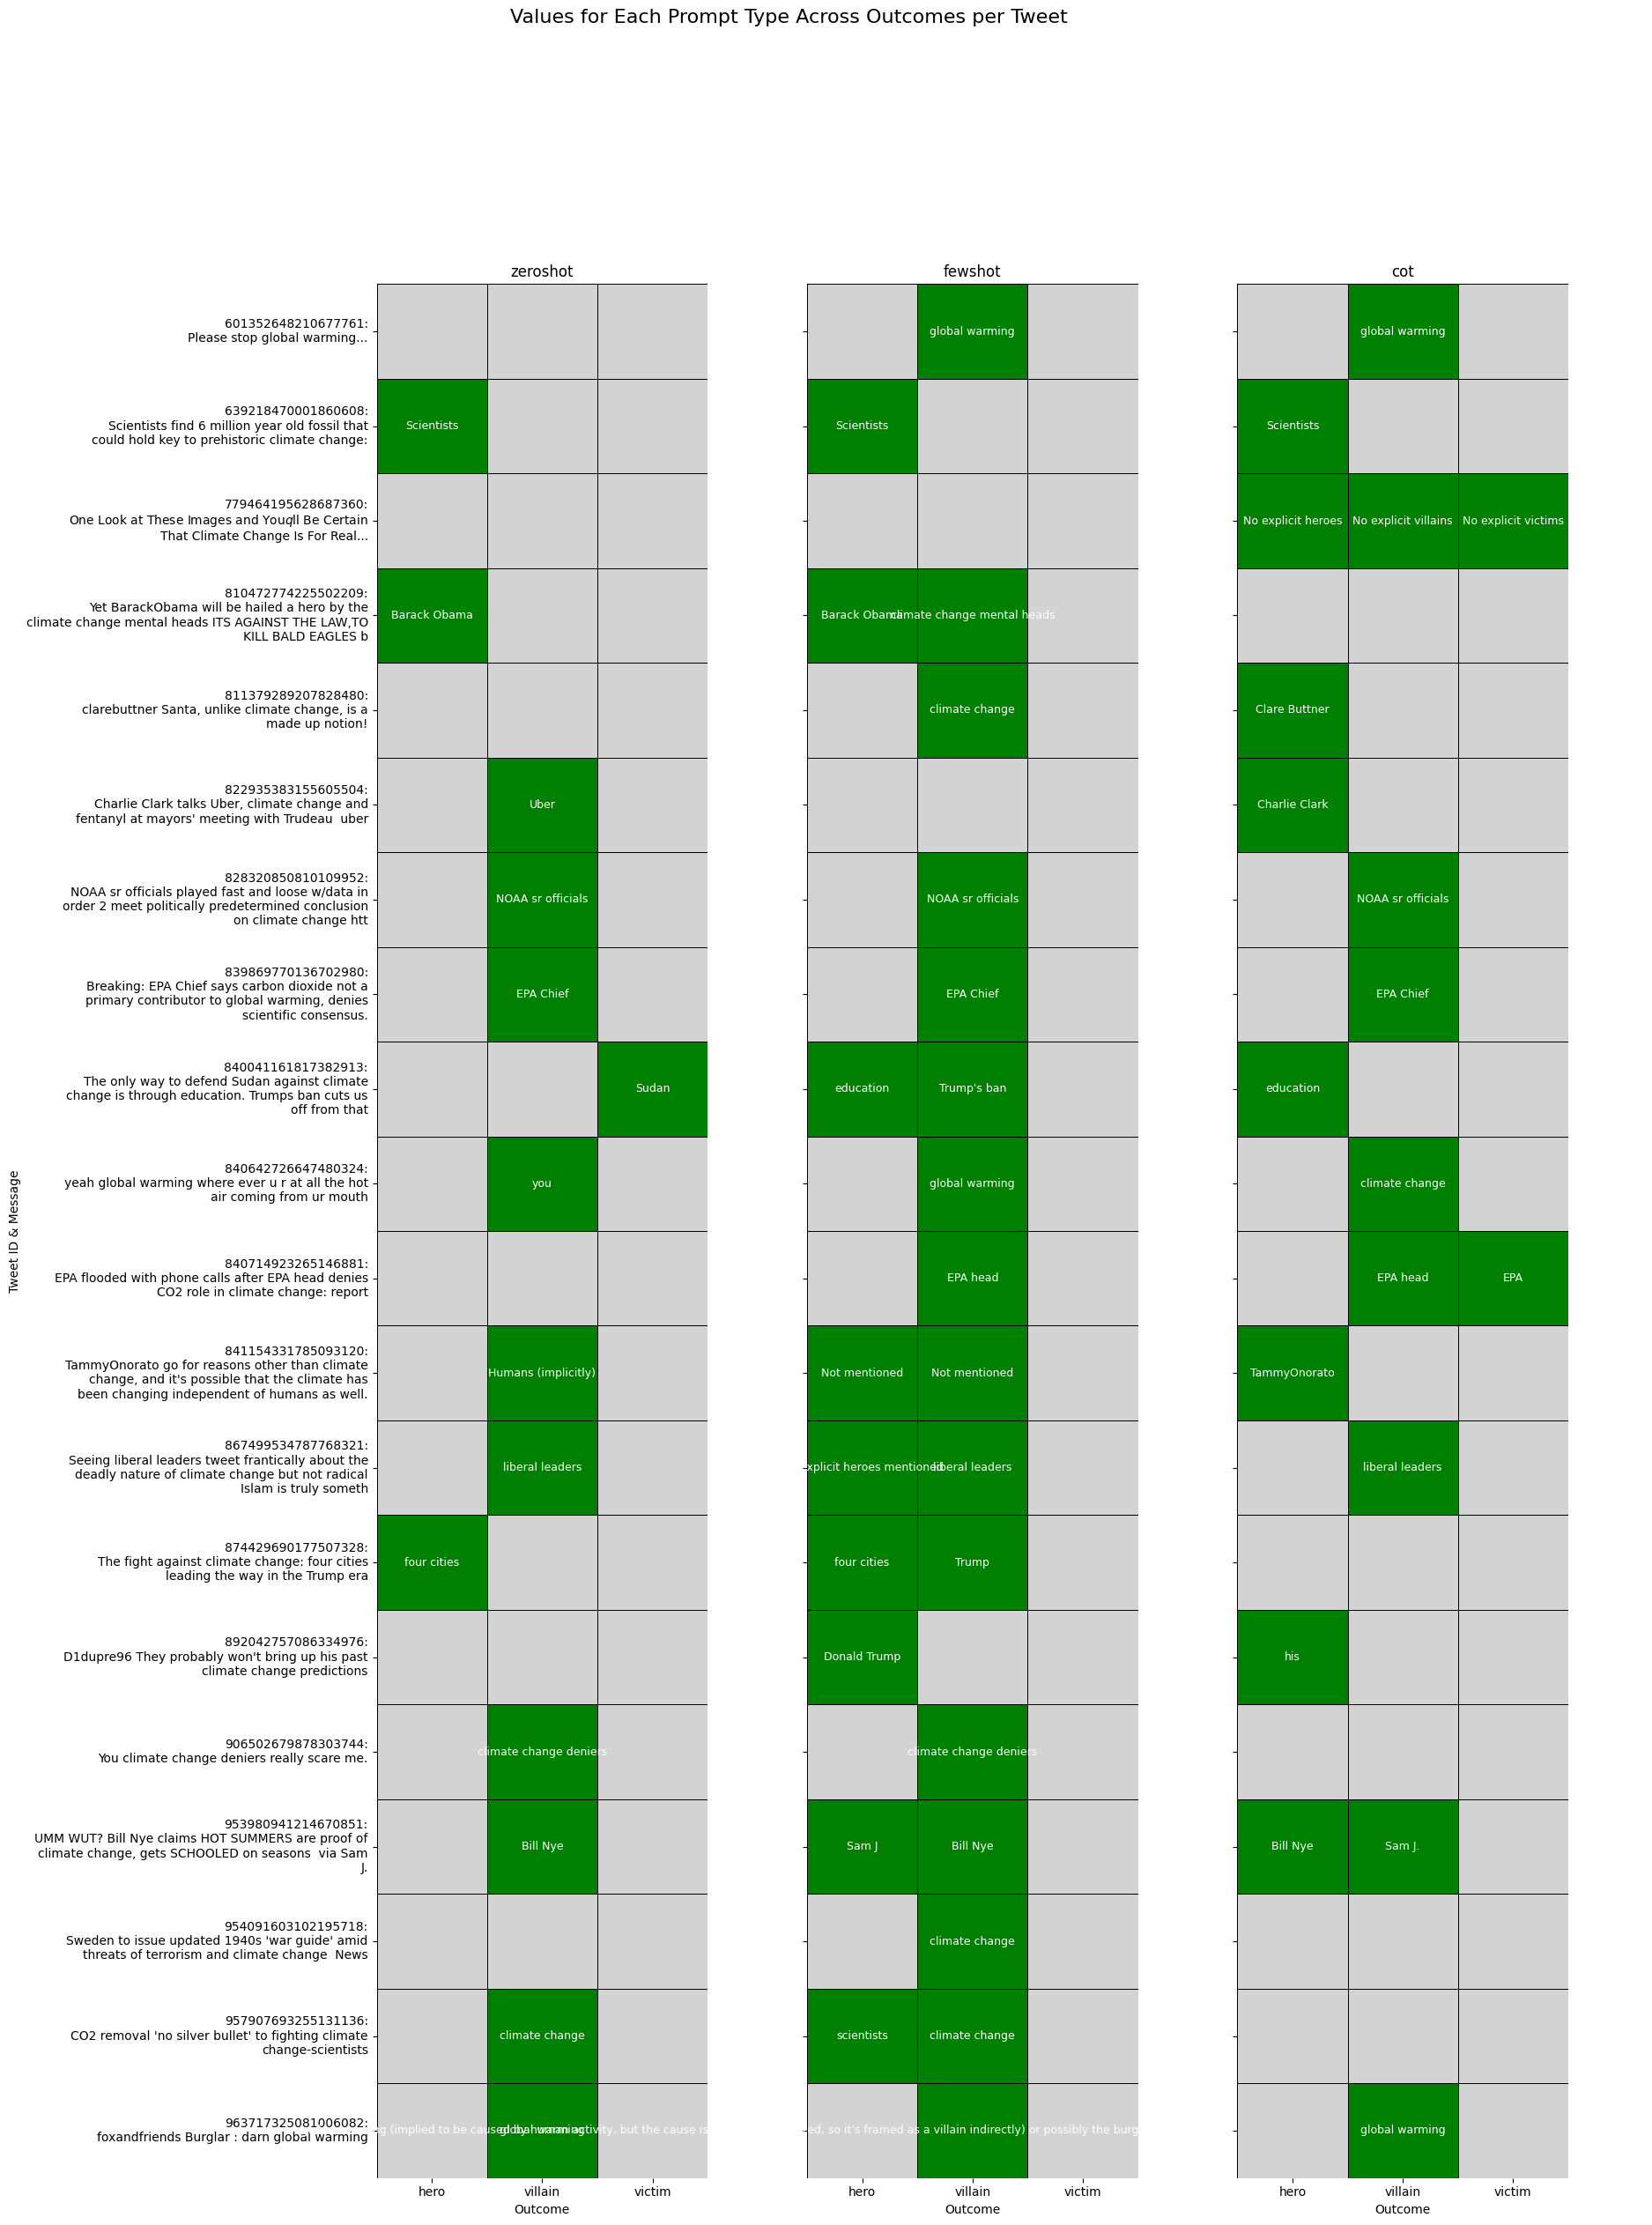

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# plot whether a hero, villain or victim was found in each df

# combine response_dfs with column for prompt_type
response_df_zeroshot['prompt_type'] = 'zeroshot'
response_df_fewshot['prompt_type'] = 'fewshot'
response_df_cot['prompt_type'] = 'cot'

# concat vertically
response_df = pd.concat([response_df_zeroshot, response_df_fewshot, response_df_cot])
response_df.sort_values(by='tweetid')

# Copy and lowercase columns first
df = response_df.copy()
df.columns = [c.lower() for c in df.columns]


outcomes = ['hero', 'villain', 'victim']

def clean_empty(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.strip().lower() in ['none', 'null', 'nulle', '']:
        return np.nan
    return x

df[outcomes] = df[outcomes].applymap(clean_empty)

df_long = df.melt(
    id_vars=['tweetid', 'prompt_type', 'clean_message'],
    value_vars=outcomes,
    var_name='outcome',
    value_name='value'
)

def wrap_text(text, width=50):
    return "\n".join(textwrap.wrap(str(text), width))

df_long['tweet_label'] = (
    df_long['tweetid'].astype(str)
    + ":\n"
    + df_long['clean_message'].apply(lambda x: wrap_text(x, 50))
)

prompt_types = list(df['prompt_type'].dropna().unique())

# --- FIGURE SIZE: make subplots wider ---
subplot_width = 6
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(prompt_types),
    figsize=(subplot_width * len(prompt_types),
             len(df['tweetid'].unique()) * 1.2),
    sharey=True
)

# Make axes iterable if only one subplot
if len(prompt_types) == 1:
    axes = [axes]

for i, prompt in enumerate(prompt_types):
    df_prompt = df_long[df_long['prompt_type'] == prompt].copy()

    # If nothing for this prompt, show empty panel
    if df_prompt.empty:
        axes[i].set_title(str(prompt))
        axes[i].axis("off")
        axes[i].text(0.5, 0.5, "No data", ha="center", va="center")
        continue

    # Pivot for presence (color)
    df_presence = df_prompt.pivot_table(
        index='tweet_label',
        columns='outcome',
        values='value',
        aggfunc=lambda x: x.notna().any()
    )

    # Pivot for annotations (text)
    df_text = df_prompt.pivot_table(
        index='tweet_label',
        columns='outcome',
        values='value',
        aggfunc=lambda x: next((v for v in x if pd.notna(v)), np.nan)
    )

    # Force all columns to exist
    df_presence = df_presence.reindex(columns=outcomes, fill_value=False)
    df_text = df_text.reindex(columns=outcomes)

    # Force both to have same row index
    df_text = df_text.reindex(index=df_presence.index)

    annot = df_text.fillna("")

    sns.heatmap(
        df_presence,
        ax=axes[i],
        cmap=['lightgrey', 'green'],
        cbar=False,
        linewidths=0.5,
        linecolor='black',
        annot=annot,
        fmt="",
        annot_kws={"size": 9}
    )

    axes[i].set_title(str(prompt))
    axes[i].set_xlabel("Outcome")
    if i == 0:
        axes[i].set_ylabel("Tweet ID & Message")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Values for Each Prompt Type Across Outcomes per Tweet", fontsize=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.3)
plt.show()


Now, **in groups** compare your results and consider the following questions:

> ✋ Did any models behave similarly?
>
> ✋ How well do you think the models agree with each other?
>
> ✋ Do you agree with with your model's output?
>
> ✋ Are there any instances where the model has really got it wrong?
>
> ✋ Did the models behave as you expected?


<br>

---
<br>

♦

# **📏 Part 6. Quantitative Analysis**


For the purpose of this exercise:
* **Assume** we are happy with our prompt/LLM outputs
* shows the impact of different prompting strategies on different models on much larger dataset (impractical to do in the workshop)

### **6.1 Classifying our Roles**

In [37]:
from typing import Literal

ActorType = Literal[
    "ENVIRONMENT",
    "CLIMATECHANGE",
    "ENVIROMENTAL_ACTIVISTS",
    "GENERAL_PUBLIC",
    "GOVERNMENTS_AND_POLITICIANS",
    "GREEN_TECHNOLOGY",
    "INDUSTRY",
    "EMISSIONS",
    "LEGISLATION_AND_POLICY",
    "MEDIA",
    "SCIENCE_AND_EXPERTS",
]
class ClassificationResponseFormat(BaseModel):
    hero: Optional[str] = None
    hero_type: Optional[ActorType] = None
    victim: Optional[str] = None
    victim_type: Optional[ActorType] = None
    villain: Optional[str] = None
    villain_type: Optional[ActorType] = None

### **6.2 Creating the prompt**

In [38]:
prompt_cot = '''
You are a helpful research assistant, interested in the framing of narratives in tweets about climate change. You have been tasked with identifying the heroes, villains and victims in a selection of tweets.
Task:
Read each tweet and decide if there is a hero, a villain or a victim, as per the following criteria:

Hero: an entity contributing to/responsible for issue resolution
Villain: an entity contributing to/responsible for issue cause
Victim: an entity suffering the consequences of an issue

Chain of thought:
1. Identify the central issue: Determine what climate-related problem or event the tweet is discussing.
2. Look for conflict or tension: Check if the tweet highlights a problem, blame, praise, or action.
3. Detect heroes: Identify entities praised for mitigating or solving the issue.
4. Detect victims: Identify entities suffering negative consequences of the issue.
5. Detect villains: Identify entities blamed for causing or worsening the issue.
6. Identify Roles: For any identified actors, assign them one of the available types to the best of your ability. Only assing roles if you have identified an actor. Any identified actor will have an allocated type

Actor Types:
    "ENVIRONMENT": The natural world including ecosystems, wildlife, and natural resources.
    "CLIMATE_CHANGE": Long-term changes in temperature, precipitation, and weather patterns caused by human activities.
    "ENVIRONMENTAL_ACTIVISTS": Individuals or groups advocating for environmental protection and sustainability.
    "GENERAL_PUBLIC": The broad populations, communities, or individuals affected by or involved in environmental issues.
    "GOVERNMENTS_AND_POLITICIANS": Authorities and elected officials responsible for creating and enforcing laws and policies.
    "GREEN_TECHNOLOGY": Innovations and technologies aimed at reducing environmental impact and promoting sustainability.
    "INDUSTRY": Businesses and sectors involved in production, manufacturing, and economic activities impacting the environment.
    "EMISSIONS": Release of pollutants or greenhouse gases into the atmosphere from various sources.
    "LEGISLATION_AND_POLICY": Laws, regulations, and guidelines designed to manage environmental and climate-related issues.
    "MEDIA": Channels and platforms that disseminate information and shape public opinion on environmental topics.
    "SCIENCE_AND_EXPERTS": Researchers and professionals providing knowledge, data, and analysis on environmental and climate matters.

Examples:
1. Theresa May's new chief of staff, Gavin Barwell, is known for his knowledgable concern about climate change
    hero: Gavin Barwell
    hero_type: "GOVERNMENTS_AND_POLITICIANS",

1. The reality of climate change impacts everyone but the truth is that poor communities suffer most...perpetuating the injustice
    victim: poor communities
    hero_type: "GENERAL_PUBLIC"
    villain: Climate Change
    villain_type: "CLIMATE_CHANGE"

1. Anti-Trump actor fights global warming, but wont give up 14 homes and private jet
    hero: Anti-Trump actor
    hero_type: "ENVIROMENTAL_ACTIVISTS"
    villain: Anti-Trump actor
    villain_type: "ENVIROMENTAL_ACTIVISTS"

Extract from the text the names of entities (people, groups, organisations) that are explicitly framed as either heroes, victims or villains. Do not make your own interpretations. If there is no hero, villain, or victim, respond with 'none'.
'''

### **6.3 Defining the response format**

In [43]:
response_format = ClassificationResponseFormat()
response_df = query_llm_prompting(df_samp, model, response_format, prompt=prompt_cot)

print(response_df[['clean_message', 'hero', 'villain', 'victim', 'hero_type', 'villain_type', 'victim_type']])

/tmp/ipython-input-4254469634.py:8: PydanticDeprecatedSince20: The `__fields__` attribute is deprecated, use the `model_fields` class property instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  cols = response_format.__fields__.keys()
100%|██████████| 20/20 [00:34<00:00,  1.74s/it]

                                                                                                                                    clean_message  \
21394                    Seeing liberal leaders tweet frantically about the deadly nature of climate change but not radical Islam is truly someth   
30417                                      UMM WUT? Bill Nye claims HOT SUMMERS are proof of climate change, gets SCHOOLED on seasons  via Sam J.   
15451  TammyOnorato go for reasons other than climate change, and it's possible that the climate has been changing independent of humans as well.   
12699                   NOAA sr officials played fast and loose w/data in order 2 meet politically predetermined conclusion on climate change htt   
9718                          Yet BarackObama will be hailed a hero by the climate change mental heads ITS AGAINST THE LAW,TO KILL BALD EAGLES b    
15128                                                                 yeah global warming where ever u r a

In [40]:
import pandas as pd

qwen_prebaked  = pd.read_pickle('https://github.com/Fonzzy1/LLM-Workshop/raw/refs/heads/main/qwen3:8b.pkl')
deepseek_prebaked = pd.read_pickle('https://github.com/Fonzzy1/LLM-Workshop/raw/refs/heads/main/deepseek-r1:8b.pkl')
gemma_prebaked = pd.read_pickle("https://github.com/Fonzzy1/LLM-Workshop/raw/refs/heads/main/gemma3:4b.pkl")
lamma_prebaked = pd.read_pickle("https://github.com/Fonzzy1/LLM-Workshop/raw/refs/heads/main/llama3.1:8b.pkl")

gemma_prebaked.head()

,sentiment,message,tweetid,sentiment_text,clean_message,hero,hero_type,victim,victim_type,villain,villain_type
34461,0,"RT @vincecable: Nice summary. Add climate change, turning presidency into family business, best friend Putin, protectionism, Mexican wall,â€¦",955713180684177408,neutral,"Nice summary. Add climate change, turning presidency into family business, best friend Putin, protectionism, Mexican wall,",none,CLIMATE_CHANGE,None,None,Trump,CLIMATE_CHANGE
20916,2,RT @CNN: Former US President Obama will speak about climate change and food supply at the 'Seeds and Chips' summit in Italy https://t.co/MC…,861896636313817089,news,Former US President Obama will speak about climate change and food supply at the 'Seeds and Chips' summit in Italy,Former US President Obama,SCIENCE_AND_EXPERTS,None,None,None,None
14218,1,RT @leftcoastbabe: EPA Sec. #ScottPruitt says CO2 doesn't cause global warming. Waiting for HHS Sec. #TomPrice to say cigarettes don't caus…,839961977766178817,pro,EPA Sec. #ScottPruitt says CO2 doesn't cause global warming. Waiting for HHS Sec. #TomPrice to say cigarettes don't caus,none,EMISSIONS,None,None,Scott Pruitt,GOVERNMENTS_AND_POLITICIANS
30674,0,RT @jennyb81112: Not much global warming going on in Texas ! https://t.co/F2VjfoNPgm,954760066531495936,neutral,Not much global warming going on in Texas !,none,ENVIRONMENT,None,None,CLIMATE_CHANGE,CLIMATE_CHANGE
32400,1,RT @PaulPolman: Increasingly companies have to deal with fall-out climate change. Cost of not acting now much higher than cost acting. Anyâ€¦,953094505875562496,pro,Increasingly companies have to deal with fall-out climate change. Cost of not acting now much higher than cost acting. Any,companies,INDUSTRY,None,None,None,None


### **6.4 Visualising the results**

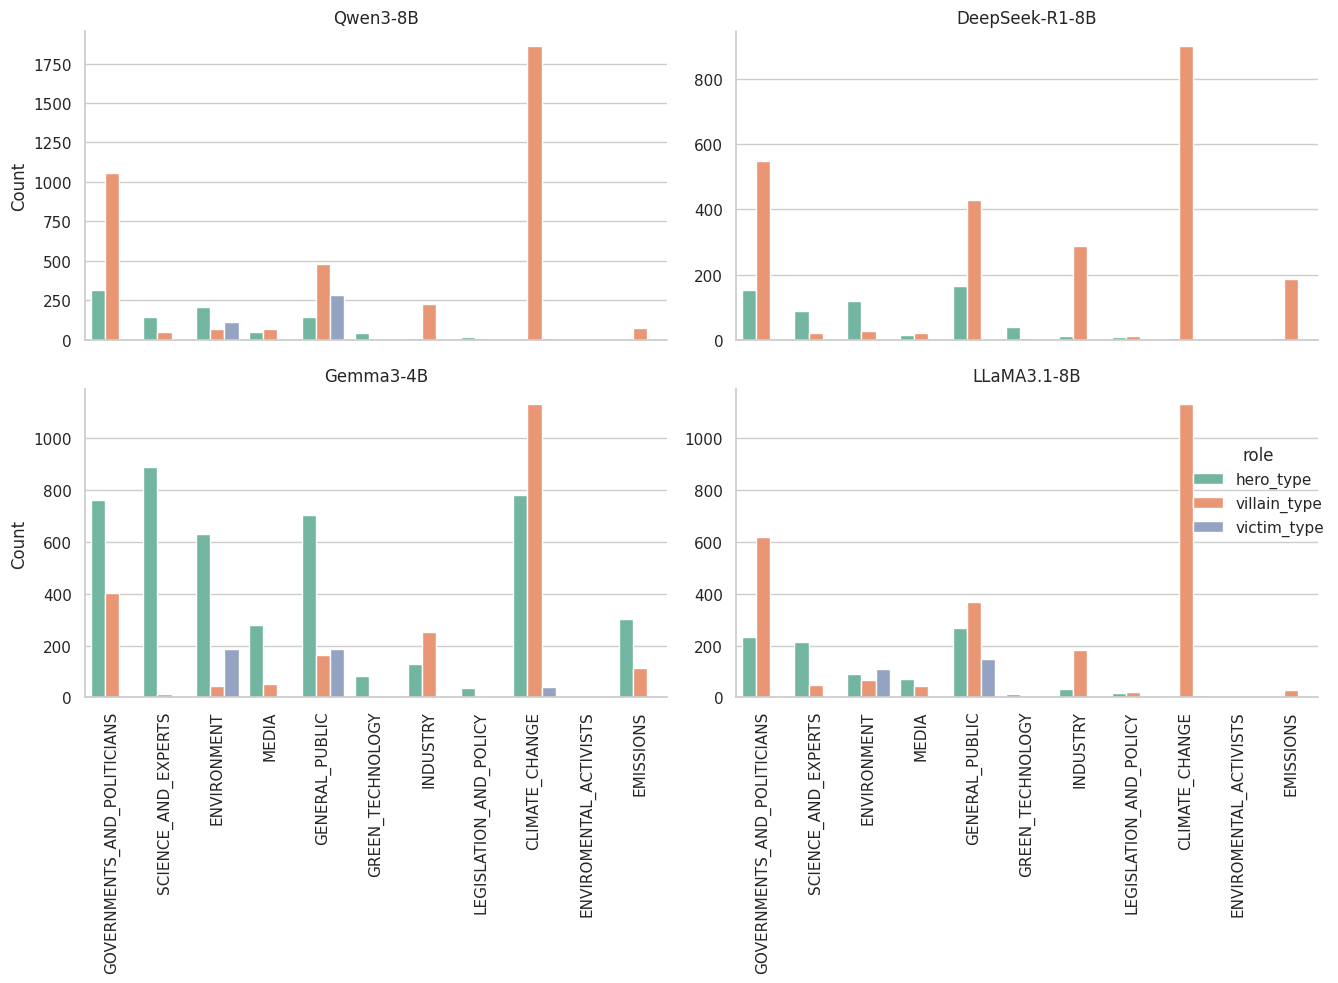

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add model labels
qwen_prebaked["model"] = "Qwen3-8B"
deepseek_prebaked["model"] = "DeepSeek-R1-8B"
gemma_prebaked["model"] = "Gemma3-4B"
lamma_prebaked["model"] = "LLaMA3.1-8B"

# Combine
df = pd.concat(
    [qwen_prebaked, deepseek_prebaked, gemma_prebaked, lamma_prebaked],
    ignore_index=True
)

# --- 3. Melt to long format ---
long_df = df.melt(
    id_vars=["tweetid", "model",'sentiment','clean_message'],  # ensure tweetid is included
    value_vars=["hero_type", "villain_type", "victim_type"],
    var_name="role",
    value_name="type"
)

import seaborn as sns
import matplotlib.pyplot as plt

# Set theme
sns.set_theme(style="whitegrid")

# Create catplot
g = sns.catplot(
    data=long_df,
    x="type",
    hue="role",          # color by role now
    col="model",         # one plot per model
    kind="count",
    height=5,
    aspect=1.2,
    sharey=False,
    palette="Set2",
    col_wrap=2           # 2x2 grid
)

# Titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("", "Count")

# Rotate x-axis labels for readability
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()






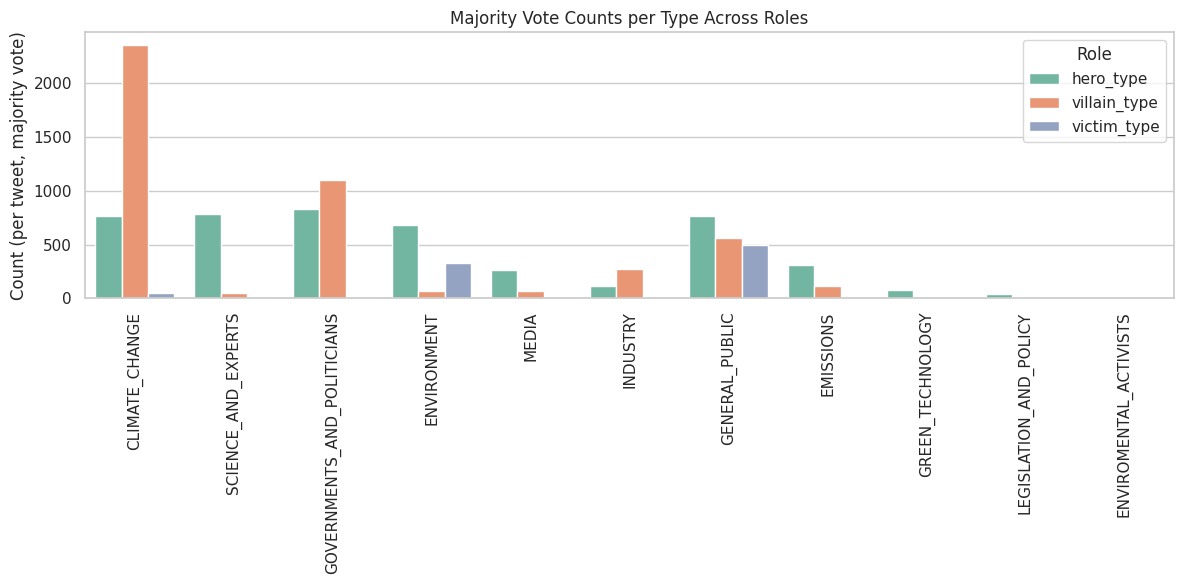

In [42]:
# Compute majority vote per tweet_id and role
# Treat None/NaN as valid
long_df["type"] = long_df["type"].where(long_df["type"].notna(), None)

# --- 4. Compute majority vote excluding None ---
def majority_vote(x):
    counts = x.value_counts(dropna=True)
    if len(counts):  # count None as a valid option
       return counts.idxmax()
    else:
      return None

majority_votes = (
    long_df.groupby(["tweetid", "role",'sentiment','clean_message'])["type"]
    .agg(majority_vote)
    .reset_index()
    .rename(columns={"type": "majority_type"})
).dropna()


# --- 5. Plot counts based on majority votes ---
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(
    data=majority_votes,
    x="majority_type",
    hue="role",
    palette="Set2"
)

plt.xlabel("")
plt.ylabel("Count (per tweet, majority vote)")
plt.xticks(rotation=90)
plt.title("Majority Vote Counts per Type Across Roles")
plt.legend(title="Role")
plt.tight_layout()
plt.show()


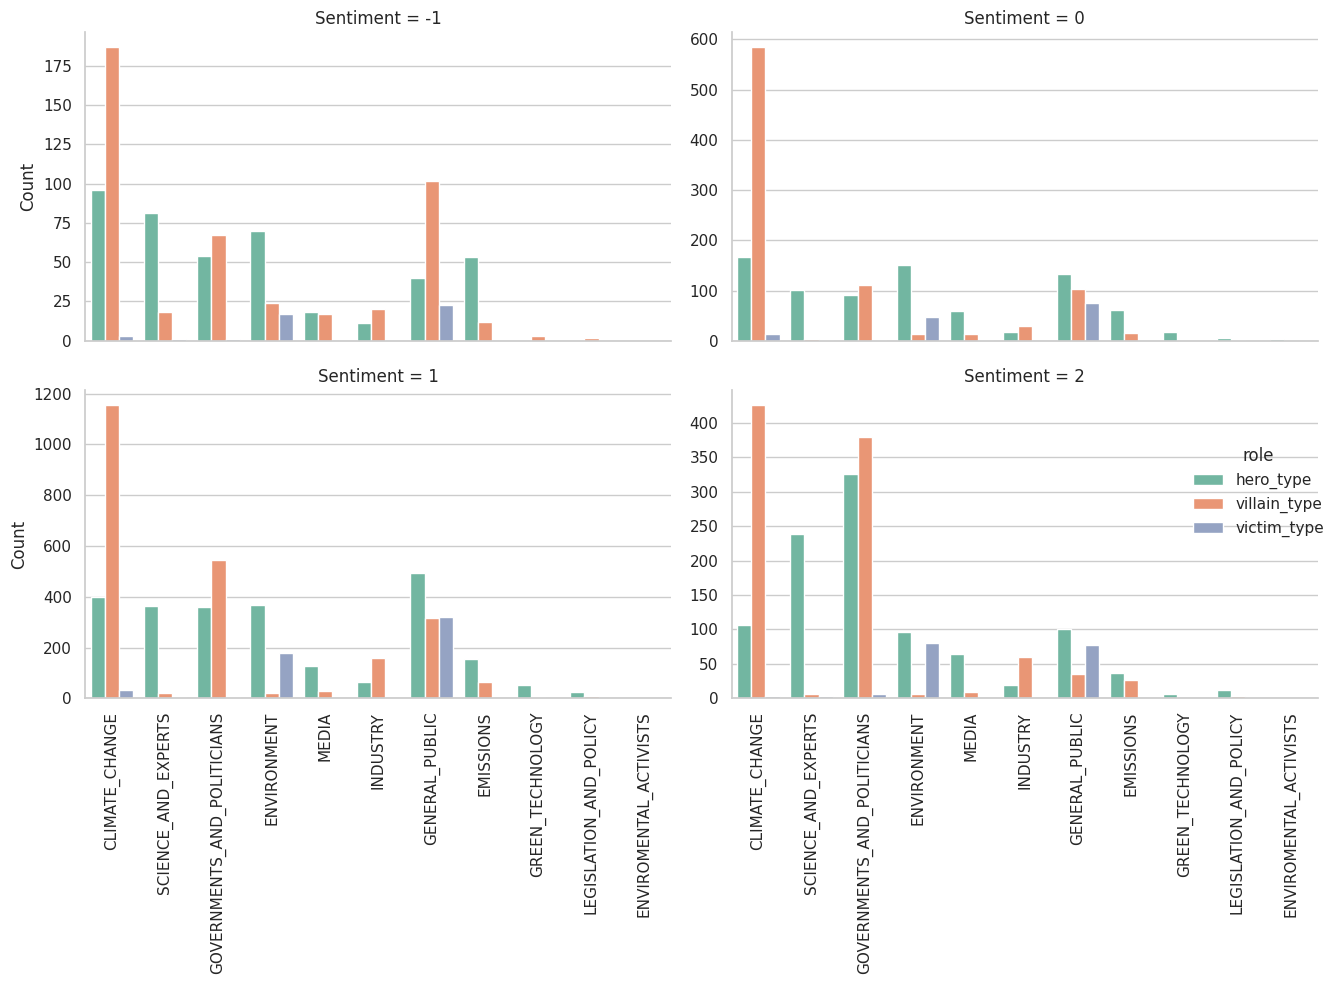

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Majority votes already computed ---
# majority_votes has columns: tweetid, role, sentiment, clean_message, majority_type

sns.set_theme(style="whitegrid")

# Use catplot to create one plot per sentiment
g = sns.catplot(
    data=majority_votes,
    x="majority_type",
    hue="role",
    col="sentiment",           # one plot per sentiment
    kind="count",
    col_wrap=2,                # 2x2 grid for 4 sentiments
    height=5,
    aspect=1.2,
    palette="Set2",
    sharey=False
)

# Titles and axis labels
g.set_titles("Sentiment = {col_name}")
g.set_axis_labels("", "Count")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=90)  # rotate x labels for readability

plt.tight_layout()
plt.show()

